In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the csv files
drugsHourly = pd.read_csv(r'C:\Users\ariki\OneDrive\שולחן העבודה\Drugs_Hourly_vaso_demo.csv', encoding = 'ISO-8859-1',)
# drugsHourly = pd.read_csv(r'Drugs_Hourly_vaso_demo.csv', encoding = 'ISO-8859-1',)
deadAlive = pd.read_csv(r'C:\Users\ariki\OneDrive\שולחן העבודה\ver12_proj3_outcomes_3-7_demo.csv', encoding = 'ISO-8859-1',)
# deadAlive = pd.read_csv(r'ver12_proj3_outcomes_3-7_demo.csv', encoding = 'ISO-8859-1',)

In [3]:
ABGLabsHourly = pd.read_excel(r"C:\Users\ariki\Downloads\ABG_Labs_hourly_20000_demo.xlsx", skiprows=[0,1,2], names=["patient_id","hour_counter",
"PaO2-1","PaO2-2","BEvt-1","BEvt-2","PotassiumABG-1","PotassiumABG-2","PH-1","PH-2","IonCalciumABG-1","IonCalciumABG-2",
"LactateABG-1","LactateABG-2","GlucoseABG-1","GlucoseABG-2","Na-ABG-1","Na-ABG-2","Chloride-ABG-1","Chloride-ABG-2",
"PaCO2-1","PaCO2-2"])
vitalHourly = pd.read_excel(r"C:\Users\ariki\Downloads\vital_hourly_20000_demo.xlsx", skiprows=[0,1,2], names=["patient_id","length of stay (hours)",
"hour_counter","ArtBPS","TEMP","HR","ArtBPD","ArtBPM","UR_h"])

In [4]:
ABGLabsHourly.drop(['BEvt-1','BEvt-2','PotassiumABG-1','PotassiumABG-2','PH-1','PH-2','IonCalciumABG-1','IonCalciumABG-2',
'GlucoseABG-1','GlucoseABG-2','Na-ABG-1','Na-ABG-2','Chloride-ABG-1','Chloride-ABG-2','PaCO2-1','PaCO2-2' ], axis=1, inplace=True)
vitalHourly.drop(['ArtBPS','TEMP','HR','ArtBPD','UR_h','length of stay (hours)'],axis=1,inplace=True)

In [5]:
#merge the two table into one
merged_df = pd.merge(drugsHourly, deadAlive, on=['patient_id'], how='inner', indicator=True)
merged_df.drop(['_merge', 'Unnamed: 0'], axis=1, inplace=True)

In [6]:
#remove lines where hour_counter<0
merged_df = merged_df[merged_df.hour_counter>=0]

In [7]:
#remove all patients who didn't get Noradrenaline
allID = merged_df.patient_id.unique()
for i in allID:
    dfID = merged_df[merged_df.patient_id==i]
    noNor = dfID[dfID["Noradrenaline (Norepinephrine)"]==0]
    if(dfID.shape[0]==noNor.shape[0]):
        merged_df = merged_df[merged_df.patient_id!=i]


In [8]:
#merge the two table into one
merged_df1 = pd.merge(merged_df, vitalHourly, on=['patient_id', 'hour_counter'], how='outer', indicator=False)
merged_df1.reset_index(drop=True)
sepsis = pd.merge(merged_df1, ABGLabsHourly, on=['patient_id', 'hour_counter'], how='outer', indicator=True)
sepsis.drop(['_merge'], axis=1, inplace=True)

In [9]:
sepsis.drop(['PaO2-1', 'PaO2-2', 'LactateABG-2'], axis=1, inplace=True)

In [10]:
sepsis.drop(['Vasopressin=Argipressin','Adrenalin (Epinephrine)','Dobutrex (Dobutamine)','Dopamine','ICU_LOS','LOS_Group'],axis=1,inplace=True)

In [11]:
sepsis = sepsis[sepsis['ICU_mortality'].notna()]
sepsis = sepsis[sepsis['Noradrenaline (Norepinephrine)'].notna()]
sepsis = sepsis.reset_index(drop=True)

In [12]:
sepsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42026 entries, 0 to 42025
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      42026 non-null  object 
 1   hour_counter                    42026 non-null  int64  
 2   Noradrenaline (Norepinephrine)  42026 non-null  float64
 3   ICU_mortality                   42026 non-null  float64
 4   ArtBPM                          431 non-null    float64
 5   LactateABG-1                    1287 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [13]:
sepsis.head(20)

,patient_id,hour_counter,Noradrenaline (Norepinephrine),ICU_mortality,ArtBPM,LactateABG-1
0,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,78.00004,NaN
1,0090EDD0-704B-4AF4-B18D-90A06A5C6514,2,0.37020,0.0,80.99998,NaN
2,0090EDD0-704B-4AF4-B18D-90A06A5C6514,3,0.34560,0.0,80.99998,NaN
3,0090EDD0-704B-4AF4-B18D-90A06A5C6514,4,0.29640,0.0,84.00001,NaN
4,0090EDD0-704B-4AF4-B18D-90A06A5C6514,5,0.26196,0.0,84.00001,NaN
5,0090EDD0-704B-4AF4-B18D-90A06A5C6514,6,0.22260,0.0,76.00000,NaN
6,0090EDD0-704B-4AF4-B18D-90A06A5C6514,7,0.22260,0.0,80.99998,NaN
7,0090EDD0-704B-4AF4-B18D-90A06A5C6514,8,0.22260,0.0,89.99997,NaN
8,0090EDD0-704B-4AF4-B18D-90A06A5C6514,9,0.22260,0.0,67.99999,NaN
9,0090EDD0-704B-4AF4-B18D-90A06A5C6514,10,0.22260,0.0,64.00000,5.0


In [14]:
# how much patient do we have
sepsis.groupby('patient_id').nunique()

,hour_counter,Noradrenaline (Norepinephrine),ICU_mortality,ArtBPM,LactateABG-1
patient_id,,,,,
0090EDD0-704B-4AF4-B18D-90A06A5C6514,37,14,1,23,2
00DC5986-2240-45A4-85E6-1619E2959E25,25,15,1,15,7
02156185-7678-425E-B4BD-F032A68FEB51,70,38,1,21,17
0215D480-878F-4B26-B789-2A24255FC723,38,3,1,25,6
024AF2B4-9FB1-4EC4-AB35-145E2E2A9B06,47,7,1,34,6
...,...,...,...,...,...
FD49A299-866F-4CA1-B6CA-E35A59ED3042,101,12,1,0,0
FE0A5748-1C49-4D38-92DE-995D31A4CE33,86,44,1,0,0
FE95A76A-8CF3-481B-B986-03C1F907E53D,124,59,1,0,0


In [15]:
print(sepsis.size)

252156


In [16]:
# fill the nan values with the closest value
import math
last = 0
for i in range (0, int(sepsis.size/sepsis.columns.size)):  
    if(not math.isnan(sepsis.loc[i,'LactateABG-1'])):
        for j in range (last, i + 1):
            a = sepsis.at[i,'LactateABG-1']
            sepsis.loc[j,'LactateABG-1'] = a
        last = i + 1


In [17]:
# import math
last = 0
for i in range (0, int(sepsis.size/sepsis.columns.size)):  
    if(not math.isnan(sepsis.loc[i,'ArtBPM'])):
        for j in range (last, i + 1):
            a = sepsis.at[i,'ArtBPM']
            sepsis.loc[j,'ArtBPM'] = a
        last = i + 1

In [18]:
sepsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42026 entries, 0 to 42025
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      42026 non-null  object 
 1   hour_counter                    42026 non-null  int64  
 2   Noradrenaline (Norepinephrine)  42026 non-null  float64
 3   ICU_mortality                   42026 non-null  float64
 4   ArtBPM                          533 non-null    float64
 5   LactateABG-1                    7576 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.9+ MB


In [19]:
sepsis = sepsis.drop_duplicates(subset=['patient_id','hour_counter'], keep='last')

In [20]:
sepsis = sepsis.reset_index(drop=True)

In [21]:
sepsis.head()

,patient_id,hour_counter,Noradrenaline (Norepinephrine),ICU_mortality,ArtBPM,LactateABG-1
0,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,78.00004,5.0
1,0090EDD0-704B-4AF4-B18D-90A06A5C6514,2,0.37020,0.0,80.99998,5.0
2,0090EDD0-704B-4AF4-B18D-90A06A5C6514,3,0.34560,0.0,80.99998,5.0
3,0090EDD0-704B-4AF4-B18D-90A06A5C6514,4,0.29640,0.0,84.00001,5.0
4,0090EDD0-704B-4AF4-B18D-90A06A5C6514,5,0.26196,0.0,84.00001,5.0


In [22]:
# a = sepsis.iloc[sepsis.hour_counter.argmax(), 1]

In [23]:
# for i in range (1, a + 1):
#     sepsis[f"{i}_Noradrenaline (Norepinephrine)"] = np.nan
#     sepsis[f"{i}_ArtBPM"] = np.nan
#     sepsis[f"{i}_LactateABG-1"] = np.nan
    


In [24]:
# take only patients who got the Nor and with hour_counter>0
sepsis = sepsis[((sepsis["Noradrenaline (Norepinephrine)"]>0) & (sepsis['ICU_mortality'] == 1)) | (sepsis['ICU_mortality'] == 0)]
sepsis = sepsis[sepsis['hour_counter'] > 0]
sepsis = sepsis.reset_index(drop=True)

In [25]:
# create new df for the models
columns = ['patient_id','ICU_mortality']
df = pd.DataFrame(columns=columns)
# df.loc[0] = ['name', 0]
df

,patient_id,ICU_mortality


In [26]:
new_sepsis = sepsis.drop_duplicates(subset=['patient_id'], keep='first')

new_sepsis = new_sepsis.reset_index(drop=True)
new_sepsis

,patient_id,hour_counter,Noradrenaline (Norepinephrine),ICU_mortality,ArtBPM,LactateABG-1
0,0090EDD0-704B-4AF4-B18D-90A06A5C6514,1,0.40037,0.0,78.00004,5.0
1,00DC5986-2240-45A4-85E6-1619E2959E25,1,1.22780,0.0,64.00000,12.0
2,02156185-7678-425E-B4BD-F032A68FEB51,1,0.73800,0.0,69.00000,50.0
3,0215D480-878F-4B26-B789-2A24255FC723,1,0.24000,0.0,95.00003,19.0
4,024AF2B4-9FB1-4EC4-AB35-145E2E2A9B06,1,0.83340,0.0,74.99999,8.0
...,...,...,...,...,...,...
581,FD49A299-866F-4CA1-B6CA-E35A59ED3042,1,0.08744,0.0,NaN,NaN
582,FE0A5748-1C49-4D38-92DE-995D31A4CE33,1,1.83890,1.0,NaN,NaN
583,FE95A76A-8CF3-481B-B986-03C1F907E53D,1,2.33040,1.0,NaN,NaN
584,FF17C5C7-B7C1-4157-AACA-C88289F75BB2,1,0.00000,0.0,NaN,NaN


In [27]:
# fill the new data with all ids and their ICU_Mortality
j = 0
for i in range (0, int(new_sepsis.size/ new_sepsis.columns.size)):
    df.loc[j] = [new_sepsis.loc[i,'patient_id'] , new_sepsis.loc[i,'ICU_mortality']]
    j = j + 1

In [28]:
df.head(10)

,patient_id,ICU_mortality
0,0090EDD0-704B-4AF4-B18D-90A06A5C6514,0.0
1,00DC5986-2240-45A4-85E6-1619E2959E25,0.0
2,02156185-7678-425E-B4BD-F032A68FEB51,0.0
3,0215D480-878F-4B26-B789-2A24255FC723,0.0
4,024AF2B4-9FB1-4EC4-AB35-145E2E2A9B06,0.0
5,0274FD92-4FF4-4BF6-894C-B3E52AE05508,1.0
6,02F70A2A-CF47-4861-8505-76EB73A44573,0.0
7,035F86D2-0E95-461D-8579-1E926F563CD7,1.0
8,03EF386E-8990-4395-AB4F-E5776F53CFF4,1.0
9,0651B8B8-153B-4E5C-953A-E9DC3968995C,0.0


In [29]:
# def create_line_for_patient(k):
#     df[f"{k}_Noradrenaline (Norepinephrine)"] = np.nan
#     df[f"{k}_ArtBPM"] = np.nan
#     df[f"{k}_LactateABG-1"] = np.nan
#     sepsis3 = sepsis[sepsis['hour_counter'] == k]
#     sepsis3 = sepsis3.reset_index(drop=True)
#     for i in range (0, int(df.size/ df.columns.size)):
#         for j in range(0 , int(sepsis3.size/ sepsis3.columns.size)):
#             if((df.loc[i,'patient_id'] == sepsis3.loc[j,'patient_id']) & (sepsis3.loc[j,'hour_counter'] == k)):
#                 df.loc[i,'1_ArtBPM'] = sepsis3.loc[j,'ArtBPM']
#                 df.loc[i,'1_Noradrenaline (Norepinephrine)'] = sepsis3.loc[j,'Noradrenaline (Norepinephrine)']
#                 df.loc[i,'1_LactateABG-1'] = sepsis3.loc[j,'LactateABG-1']

In [30]:
# a = sepsis.iloc[sepsis.hour_counter.argmax(), 1]
# for i in range(1, a + 1):
#     create_line_for_patient(i)

In [31]:
def create_line_for_patient(k, df):
    df[f"{k}_Noradrenaline (Norepinephrine)"] = np.nan
    df[f"{k}_ArtBPM"] = np.nan
    df[f"{k}_LactateABG-1"] = np.nan
    sepsis3 = sepsis[sepsis['hour_counter'] == k]
    sepsis3 = sepsis3.reset_index(drop=True)
    for i in range (0, int(df.size/ df.columns.size)):
        for j in range(0 , int(sepsis3.size/ sepsis3.columns.size)):
            if((df.loc[i,'patient_id'] == sepsis3.loc[j,'patient_id']) & (sepsis3.loc[j,'hour_counter'] == k)):
                df.loc[i,f"{k}_ArtBPM"] = sepsis3.loc[j,'ArtBPM']
                df.loc[i,f"{k}_Noradrenaline (Norepinephrine)"] = sepsis3.loc[j,'Noradrenaline (Norepinephrine)']
                df.loc[i,f"{k}_LactateABG-1"] = sepsis3.loc[j,'LactateABG-1']

In [32]:
# sepsis3 = sepsis[sepsis['patient_id'] == 'FE95A76A-8CF3-481B-B986-03C1F907E53D'
#                 ]
# sepsis3 = sepsis3.reset_index(drop=True)
# sepsis3.head(60)

In [33]:
a = sepsis.iloc[sepsis.hour_counter.argmax(), 1]
for i in range(1, a + 1):
    create_line_for_patient(i , df)

In [34]:
df

,patient_id,ICU_mortality,1_Noradrenaline (Norepinephrine),1_ArtBPM,1_LactateABG-1,2_Noradrenaline (Norepinephrine),2_ArtBPM,2_LactateABG-1,3_Noradrenaline (Norepinephrine),3_ArtBPM,...,165_LactateABG-1,166_Noradrenaline (Norepinephrine),166_ArtBPM,166_LactateABG-1,167_Noradrenaline (Norepinephrine),167_ArtBPM,167_LactateABG-1,168_Noradrenaline (Norepinephrine),168_ArtBPM,168_LactateABG-1
0,0090EDD0-704B-4AF4-B18D-90A06A5C6514,0.0,0.40037,78.00004,5.0,0.37020,80.99998,5.0,0.34560,80.99998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00DC5986-2240-45A4-85E6-1619E2959E25,0.0,1.22780,64.00000,12.0,1.48200,67.99999,11.0,1.48200,67.99999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02156185-7678-425E-B4BD-F032A68FEB51,0.0,0.73800,69.00000,50.0,0.82880,69.00000,86.0,1.04800,69.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0215D480-878F-4B26-B789-2A24255FC723,0.0,0.24000,95.00003,19.0,0.24000,92.00002,19.0,0.24000,88.99999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,024AF2B4-9FB1-4EC4-AB35-145E2E2A9B06,0.0,0.83340,74.99999,8.0,0.80870,73.99998,7.0,0.55624,71.99999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,FD49A299-866F-4CA1-B6CA-E35A59ED3042,0.0,0.08744,NaN,NaN,0.13952,NaN,NaN,0.14820,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582,FE0A5748-1C49-4D38-92DE-995D31A4CE33,1.0,1.83890,NaN,NaN,2.94600,NaN,NaN,2.76540,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583,FE95A76A-8CF3-481B-B986-03C1F907E53D,1.0,2.33040,NaN,NaN,1.95000,NaN,NaN,1.11000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
584,FF17C5C7-B7C1-4157-AACA-C88289F75BB2,0.0,0.00000,NaN,NaN,0.00000,NaN,NaN,0.00000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# x = pd.DataFrame(df.iloc[:15,1 :32])
# x

In [36]:
#Now seperate the dataset as response variable and feature variabes
from sklearn.model_selection import train_test_split, cross_val_score
for i in range(1, 12):
    df = df[df[f'{i}_Noradrenaline (Norepinephrine)'].notnull()]
feature = ['1_Noradrenaline (Norepinephrine)',
           '2_Noradrenaline (Norepinephrine)',
           '3_Noradrenaline (Norepinephrine)',
           '4_Noradrenaline (Norepinephrine)',
           '5_Noradrenaline (Norepinephrine)',
           '6_Noradrenaline (Norepinephrine)',
           '7_Noradrenaline (Norepinephrine)',
           '8_Noradrenaline (Norepinephrine)',
           '9_Noradrenaline (Norepinephrine)',
           '10_Noradrenaline (Norepinephrine)',
          'ICU_mortality']
X = df[feature]
Y = df['ICU_mortality']

#Train and Test splitting of data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)
X

,1_Noradrenaline (Norepinephrine),2_Noradrenaline (Norepinephrine),3_Noradrenaline (Norepinephrine),4_Noradrenaline (Norepinephrine),5_Noradrenaline (Norepinephrine),6_Noradrenaline (Norepinephrine),7_Noradrenaline (Norepinephrine),8_Noradrenaline (Norepinephrine),9_Noradrenaline (Norepinephrine),10_Noradrenaline (Norepinephrine),ICU_mortality
0,0.40037,0.37020,0.3456,0.29640,0.26196,0.22260,0.22260,0.2226,0.22260,0.22260,0.0
1,1.22780,1.48200,1.4820,1.48200,1.48200,1.47790,1.33800,1.3055,1.18800,1.18800,0.0
2,0.73800,0.82880,1.0480,0.94933,0.31980,0.31980,0.20128,0.6825,0.81780,0.81780,0.0
3,0.24000,0.24000,0.2400,0.24000,0.24000,0.24000,0.24000,0.2400,0.24000,0.24000,0.0
5,0.08880,0.22200,0.2220,0.22200,0.22200,0.22200,0.22200,0.2220,0.22200,0.22200,1.0
...,...,...,...,...,...,...,...,...,...,...,...
581,0.08744,0.13952,0.1482,0.14820,0.14999,0.23455,0.34008,0.3696,0.36960,0.36960,0.0
582,1.83890,2.94600,2.7654,2.67100,2.58120,2.49900,2.45310,2.4480,4.53359,7.38462,1.0
583,2.33040,1.95000,1.1100,1.11000,1.11000,1.11000,1.11010,1.1160,1.02720,0.89400,1.0
584,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0


In [37]:
#Logistic Regression

# import the class
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train , Y_train)

# store the predicted response values
y_pred = logreg.predict(X_test)

# compute classification accuracy for the logistic regression model
accuracy = accuracy_score(Y_test, y_pred)
print('%',(accuracy *100))

% 100.0


In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200) #create the model, The number of trees in the forest.

#Enter the data training to the model, build a forest of trees from the training set.
rfc.fit(X_train, Y_train)

#Predict class for X.
pred_rfc = rfc.predict(X_test)
print(pred_rfc)

#Accuracy percentages
accuracy =  rfc.score(X_test, Y_test)

print('% Random forest classifier accuracy:', accuracy*100)

[1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
% Random forest classifier accuracy: 100.0


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#create the model
knn = KNeighborsClassifier(n_neighbors=1)

#Enter the data training to the mode
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(Y_test, y_pred))

0.9626865671641791


In [40]:
# using cross validation to get the best percentage of success

k_range = list(range(1, 40))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k,weights='distance',p=1)
    scores = cross_val_score(knn, X_train, Y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.9592592592592591, 0.9592592592592591, 0.9666666666666666, 0.9666666666666666, 0.9703703703703704, 0.9740740740740742, 0.9555555555555557, 0.951851851851852, 0.9481481481481483, 0.9444444444444444, 0.9481481481481483, 0.9370370370370372, 0.937037037037037, 0.9333333333333333, 0.9296296296296296, 0.9222222222222222, 0.9185185185185185, 0.9259259259259259, 0.9185185185185185, 0.9222222222222223, 0.9074074074074074, 0.9185185185185185, 0.9074074074074074, 0.9111111111111111, 0.9, 0.9, 0.8925925925925926, 0.9037037037037037, 0.8962962962962961, 0.8962962962962961, 0.8888888888888887, 0.8925925925925926, 0.8851851851851851, 0.8851851851851851, 0.8851851851851851, 0.8851851851851851, 0.8851851851851851, 0.8851851851851851, 0.874074074074074]


Text(0, 0.5, 'Cross validation Accuracy')

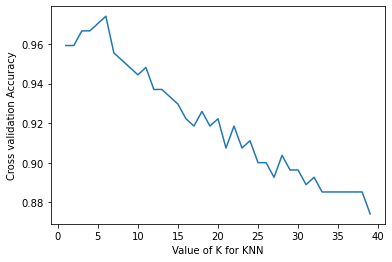

In [41]:
# graph of the value of k (x) and the cross validation accuracy 
plt.plot(k_range, k_scores)
#names of x and y
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross validation Accuracy')

In [42]:
#Now seperate the dataset as response variable and feature variabes
from sklearn.model_selection import train_test_split, cross_val_score
for i in range(1, 12):
    df = df[df[f'{i}_Noradrenaline (Norepinephrine)'].notnull()]
for i in range(1, 12):
    df = df[df[f'{i}_LactateABG-1'].notnull()]
feature = ['1_Noradrenaline (Norepinephrine)','1_LactateABG-1',
           '2_Noradrenaline (Norepinephrine)','2_LactateABG-1',
           '3_Noradrenaline (Norepinephrine)','3_LactateABG-1',
           '4_Noradrenaline (Norepinephrine)','4_LactateABG-1',
           '5_Noradrenaline (Norepinephrine)','5_LactateABG-1',
           '6_Noradrenaline (Norepinephrine)','6_LactateABG-1',
           '7_Noradrenaline (Norepinephrine)','7_LactateABG-1',
           '8_Noradrenaline (Norepinephrine)','8_LactateABG-1',
           '9_Noradrenaline (Norepinephrine)','9_LactateABG-1',
           '10_Noradrenaline (Norepinephrine)','10_LactateABG-1'
           , 'ICU_mortality']
X = df[feature]
Y = df['ICU_mortality']

#Train and Test splitting of data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)
X

,1_Noradrenaline (Norepinephrine),1_LactateABG-1,2_Noradrenaline (Norepinephrine),2_LactateABG-1,3_Noradrenaline (Norepinephrine),3_LactateABG-1,4_Noradrenaline (Norepinephrine),4_LactateABG-1,5_Noradrenaline (Norepinephrine),5_LactateABG-1,...,6_LactateABG-1,7_Noradrenaline (Norepinephrine),7_LactateABG-1,8_Noradrenaline (Norepinephrine),8_LactateABG-1,9_Noradrenaline (Norepinephrine),9_LactateABG-1,10_Noradrenaline (Norepinephrine),10_LactateABG-1,ICU_mortality
0,0.40037,5.0,0.37020,5.0,0.34560,5.0,0.29640,5.000000,0.26196,5.000000,...,5.0,0.22260,5.0,0.22260,5.000000,0.2226,5.000000,0.2226,5.0,0.0
1,1.22780,12.0,1.48200,11.0,1.48200,12.0,1.48200,9.999999,1.48200,9.999999,...,11.0,1.33800,11.0,1.30550,9.999999,1.1880,9.999999,1.1880,11.0,0.0
2,0.73800,50.0,0.82880,86.0,1.04800,86.0,0.94933,86.000000,0.31980,86.000000,...,86.0,0.20128,86.0,0.68250,86.000000,0.8178,75.000000,0.8178,75.0,0.0
3,0.24000,19.0,0.24000,19.0,0.24000,19.0,0.24000,36.000000,0.24000,36.000000,...,36.0,0.24000,36.0,0.24000,36.000000,0.2400,36.000000,0.2400,25.0,0.0
5,0.08880,48.0,0.22200,48.0,0.22200,48.0,0.22200,48.000000,0.22200,48.000000,...,48.0,0.22200,48.0,0.22200,48.000000,0.2220,48.000000,0.2220,48.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1.14360,14.0,1.17720,21.0,1.20102,21.0,0.92550,25.000000,1.02000,26.000000,...,26.0,0.96600,20.0,0.96600,20.000000,0.8260,20.000000,0.6812,26.0,0.0
98,1.18800,13.0,1.18800,13.0,1.18800,13.0,1.18800,13.000000,1.18800,13.000000,...,13.0,1.18800,13.0,1.18800,12.000000,1.1880,12.000000,1.1880,12.0,0.0
99,0.00000,29.0,0.00000,29.0,0.00000,29.0,0.00000,32.000000,0.37691,32.000000,...,32.0,0.74400,34.0,0.69612,34.000000,0.5928,34.000000,0.5928,34.0,0.0
101,0.00000,12.0,0.00000,12.0,0.00000,12.0,0.00000,12.000000,0.00000,12.000000,...,12.0,0.00000,12.0,0.00000,12.000000,0.0000,6.000000,0.0000,6.0,0.0


In [43]:
#Logistic Regression

# import the class
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train , Y_train)

# store the predicted response values
y_pred = logreg.predict(X_test)

# compute classification accuracy for the logistic regression model
accuracy = accuracy_score(Y_test, y_pred)
print('%',(accuracy *100))

% 88.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200) #create the model, The number of trees in the forest.

#Enter the data training to the model, build a forest of trees from the training set.
rfc.fit(X_train, Y_train)

#Predict class for X.
pred_rfc = rfc.predict(X_test)
print(pred_rfc)

#Accuracy percentages
accuracy =  rfc.score(X_test, Y_test)

print('% Random forest classifier accuracy:', accuracy*100)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0.]
% Random forest classifier accuracy: 84.0


In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#create the model
knn = KNeighborsClassifier(n_neighbors=1)

#Enter the data training to the mode
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(Y_test, y_pred))

0.72
